In [1]:
import pandas as pd
data = pd.read_csv("E:/LBSIM/FRP/Final Data.csv")
data

,Date,Open Price,Last Price,Compound,Sentiment,Change
0,1-Nov-18,8874.750,8814.200,0.100140,Positive,54.20
1,2-Nov-18,8907.400,9180.200,0.413930,Positive,93.20
2,3-Nov-18,9190.050,9190.050,0.238644,Positive,9.85
3,4-Nov-18,9190.050,9190.050,0.221640,Positive,0.00
4,5-Nov-18,9199.900,9153.650,-0.013840,Neutral,9.85
...,...,...,...,...,...,...
360,27-Oct-19,8086.400,8102.000,0.193970,Positive,50.02
361,28-Oct-19,8117.625,8117.625,0.282990,Positive,15.63
362,29-Oct-19,8133.250,8449.750,0.444867,Positive,15.63
363,30-Oct-19,8501.150,8428.900,-0.051210,Negative,51.40


In [2]:
#Importing necessary libraries
import numpy as np
import pandas as pd
from sklearn import preprocessing

from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.layers.recurrent import LSTM
from keras.layers import  Dropout
from keras import regularizers
from keras.layers.recurrent import GRU

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
fmt = '$%.0f'
tick = mtick.FormatStrFormatter(fmt)

Using TensorFlow backend.


In [3]:
percentage_of_data = 1.0
data_to_use = int(percentage_of_data*(len(data)-1))

# 80% of data will be of training
train_end = int(data_to_use*0.8)

total_data = len(data)
print("total_data:", total_data)

total_data: 365


In [4]:
start = total_data - data_to_use

# Currently doing prediction only for 1 step ahead
steps_to_predict = 1

#compund, change
yt1 = data.iloc[start:total_data,3] #compund
yt3 = data.iloc[start:total_data,5] #change

print("yt head (change) :")
print(yt3.head())

yt head (change) :
1    93.20
2     9.85
3     0.00
4     9.85
5    45.20
Name: Change, dtype: float64


In [5]:
#Shift next day change and next day compund
yt1_ = yt1.shift(-1) #shifted compund
yt3_ = yt3.shift(-1) #shifted change

#taking only: close, next_close, compund, next_compund, open
data = pd.concat([yt1, yt1_, yt3, yt3_], axis=1)
data.columns = ['Compound', 'Next Compound', 'Change', 'Next Change']

data = data.dropna()
     
print(data[:10])

    Compound  Next Compound  Change  Next Change
1   0.413930       0.238644   93.20         9.85
2   0.238644       0.221640    9.85         0.00
3   0.221640      -0.013840    0.00         9.85
4  -0.013840       0.252240    9.85        45.20
5   0.252240       0.267056   45.20        88.85
6   0.267056       0.301180   88.85         7.35
7   0.301180       0.056660    7.35         7.35
8   0.056660       0.222610    7.35         6.63
9   0.222610       0.289000    6.63         0.00
10  0.289000       0.110990    0.00         6.63


In [6]:
#Target variable - Change in price
#After shifting
y = data['Next Change']

#compund, next_compund, change 
cols = ['Compound', 'Next Compound', 'Change']
x = data[cols]

In [7]:
#Normalizing the data
scaler_x = preprocessing.MinMaxScaler(feature_range=(-1, 1))
x = np.array(x).reshape((len(x) ,len(cols)))
x = scaler_x.fit_transform(x)

scaler_y = preprocessing.MinMaxScaler(feature_range=(-1, 1))
y = np.array(y).reshape((len(y), 1))
y = scaler_y.fit_transform(y)

In [8]:
X_train = x[0 : train_end,]
X_test = x[train_end+1 : len(x),]    
y_train = y[0 : train_end] 
y_test = y[train_end+1 : len(y)]  

X_train = X_train.reshape (X_train. shape + (1,)) 
X_test = X_test.reshape(X_test.shape + (1,))

In [9]:
#Long-Short Term Memory
batch_size = 32
nb_epoch = 100
neurons = 25
dropout = 0.1

seed = 2016
np.random.seed(seed)

model = Sequential()
model.add(LSTM(neurons, return_sequences=True, activation='tanh', inner_activation='hard_sigmoid', input_shape=(len(cols), 1)))
model.add(Dropout(dropout))
model.add(LSTM(neurons, return_sequences=True,  activation='tanh'))
model.add(Dropout(dropout))
model.add(LSTM(neurons, activation='tanh'))
model.add(Dropout(dropout))

model.add(Dense(activity_regularizer=regularizers.l1(0.00001), output_dim=1, activation='linear'))
model.add(Activation('tanh'))

print(model.summary())

model.compile(loss='mse' , optimizer='adam')
history_lstm = model.fit(X_train, y_train, batch_size=batch_size, nb_epoch=nb_epoch, verbose=1, validation_split=0.2)

C:\Users\Ssinghal\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(25, return_sequences=True, activation="tanh", input_shape=(3, 1), recurrent_activation="hard_sigmoid")`
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Ssinghal\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activity_regularizer=<keras.reg..., activation="linear", units=1)`
C:\Users\Ssinghal\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 3, 25)             2700      
_________________________________________________________________
dropout_1 (Dropout)          (None, 3, 25)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 3, 25)             5100      
_________________________________________________________________
dropout_2 (Dropout)          (None, 3, 25)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 25)                5100      
_________________________________________________________________
dropout_3 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

232/232 [==============================] - 0s 1ms/step - loss: 0.0436 - val_loss: 0.0198
Epoch 68/100
232/232 [==============================] - 0s 1ms/step - loss: 0.0438 - val_loss: 0.0189
Epoch 69/100
232/232 [==============================] - 0s 1ms/step - loss: 0.0433 - val_loss: 0.0190
Epoch 70/100
232/232 [==============================] - 0s 2ms/step - loss: 0.0438 - val_loss: 0.0195
Epoch 71/100
232/232 [==============================] - 0s 1ms/step - loss: 0.0438 - val_loss: 0.0194
Epoch 72/100
232/232 [==============================] - 0s 1ms/step - loss: 0.0431 - val_loss: 0.0189
Epoch 73/100
232/232 [==============================] - 0s 1ms/step - loss: 0.0431 - val_loss: 0.0198
Epoch 74/100
232/232 [==============================] - 0s 1ms/step - loss: 0.0434 - val_loss: 0.0192
Epoch 75/100
232/232 [==============================] - 0s 1ms/step - loss: 0.0438 - val_loss: 0.0196
Epoch 76/100
232/232 [==============================] - 0s 1ms/step - loss: 0.0437 - val_loss: 

In [10]:
#Measuring Mean Squared Error for LSTM model
score_train = model.evaluate(X_train, y_train, batch_size =1)
score_test = model.evaluate(X_test, y_test, batch_size =1)
print("in train MSE = ", round(score_train ,4)) 
print("in test MSE = ", score_test)

71/71 [==============================] - 1s 10ms/step
in train MSE =  0.0381
in test MSE =  0.03637815923055724


In [11]:
#Making predictions from LSTM model
pred = model.predict(X_test) 

C:\Users\Ssinghal\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':


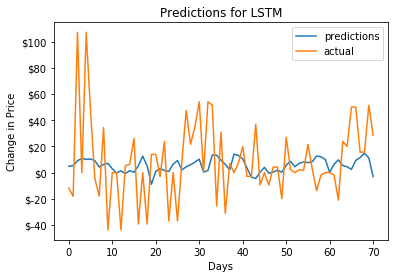

<Figure size 432x288 with 0 Axes>

In [18]:
#Plotting predicted and actual values of LSTM
pred_inverse = scaler_y.inverse_transform(np.array(pred).reshape((len(pred), 1)))

X_test_inverse = scaler_x.inverse_transform(np.array(X_test).reshape((len(X_test), len(cols))))
plt.plot(pred_inverse, label="predictions")

y_test_inverse = scaler_y.inverse_transform(np.array(y_test).reshape((len(y_test), 1)))
plt.plot([row[0] for row in y_test_inverse], label="actual")

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=2)

ax = plt.axes()
ax.yaxis.set_major_formatter(tick)
plt.xlabel('Days')
plt.ylabel('Change in Price')
plt.legend()
plt.title('Predictions for LSTM')
plt.show()
plt.clf()

In [13]:
#Gated Recurrent Unit
model1 = Sequential()
model1.add(GRU(output_dim=1,activation='tanh',recurrent_activation='hard_sigmoid',input_shape=(len(cols), 1)))
model1.add(Dense(activity_regularizer=regularizers.l1(0.00001), output_dim=1, activation='linear'))

model1.add(Dense(1))
model1.add(Activation('sigmoid'))

print(model1.summary())

model1.compile(loss='mean_squared_error',
              optimizer='adam')

history_gru = model1.fit(X_train, y_train, batch_size=batch_size, nb_epoch=nb_epoch, verbose=1, validation_split=0.2)

C:\Users\Ssinghal\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `GRU` call to the Keras 2 API: `GRU(activation="tanh", recurrent_activation="hard_sigmoid", input_shape=(3, 1), units=1)`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Ssinghal\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activity_regularizer=<keras.reg..., activation="linear", units=1)`
  after removing the cwd from sys.path.
C:\Users\Ssinghal\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 1)                 9         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 2         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 2         
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0         
Total params: 13
Trainable params: 13
Non-trainable params: 0
_________________________________________________________________
None
Train on 232 samples, validate on 59 samples
Epoch 1/100
232/232 [==============================] - 3s 14ms/step - loss: 0.0855 - val_loss: 0.0928
Epoch 2/100
232/232 [==============================] - 0s 814us/step - loss: 0.0826 - val_loss: 0.0891
E

232/232 [==============================] - 0s 823us/step - loss: 0.0457 - val_loss: 0.0259
Epoch 72/100
232/232 [==============================] - 0s 823us/step - loss: 0.0457 - val_loss: 0.0258
Epoch 73/100
232/232 [==============================] - 0s 883us/step - loss: 0.0457 - val_loss: 0.0257
Epoch 74/100
232/232 [==============================] - 0s 771us/step - loss: 0.0457 - val_loss: 0.0256
Epoch 75/100
232/232 [==============================] - 0s 814us/step - loss: 0.0457 - val_loss: 0.0255
Epoch 76/100
232/232 [==============================] - 0s 862us/step - loss: 0.0456 - val_loss: 0.0255
Epoch 77/100
232/232 [==============================] - 0s 909us/step - loss: 0.0456 - val_loss: 0.0254
Epoch 78/100
232/232 [==============================] - 0s 995us/step - loss: 0.0456 - val_loss: 0.0253
Epoch 79/100
232/232 [==============================] - 0s 849us/step - loss: 0.0456 - val_loss: 0.0252
Epoch 80/100
232/232 [==============================] - 0s 922us/step - loss:

In [14]:
#Measuring Mean Squared Error for GRU model
score_train = model1.evaluate(X_train, y_train, batch_size =1)
score_test = model1.evaluate(X_test, y_test, batch_size =1)
print("in train MSE = ", score_train)
print("in test MSE = ", score_test)

71/71 [==============================] - 1s 8ms/step
in train MSE =  0.04094156340874228
in test MSE =  0.037245898593950263


In [15]:
#Making predictions from GRU model
pred1 = model1.predict(X_test)

C:\Users\Ssinghal\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':


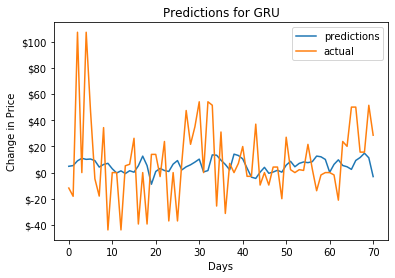

<Figure size 432x288 with 0 Axes>

In [19]:
#Plotting predicted and actual values of GRU
pred1_inverse = scaler_y.inverse_transform(np.array(pred1).reshape((len(pred1), 1)))

X_test_inverse = scaler_x.inverse_transform(np.array(X_test).reshape((len(X_test), len(cols))))
plt.plot(pred_inverse, label="predictions")

y_test_inverse = scaler_y.inverse_transform(np.array(y_test).reshape((len(y_test), 1)))
plt.plot([row[0] for row in y_test_inverse], label="actual")

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=2)

ax = plt.axes()
ax.yaxis.set_major_formatter(tick)
plt.xlabel('Days')
plt.ylabel('Change in Price')
plt.legend()
plt.title('Predictions for GRU')
plt.show()
plt.clf()

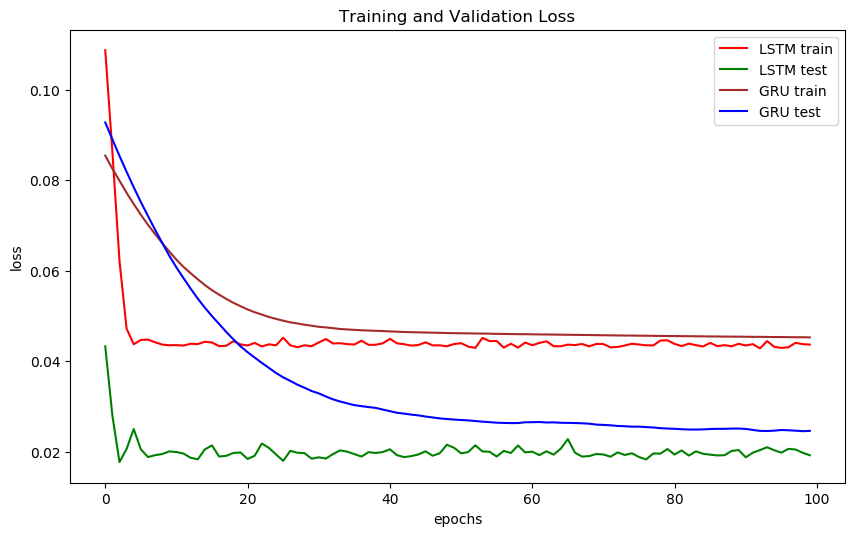

In [17]:
#Diagnosing behaviour of both the models
plt.figure(figsize=(10, 6), dpi=100)
plt.plot(history_lstm.history['loss'], label='LSTM train', color='red')
plt.plot(history_lstm.history['val_loss'], label='LSTM test', color= 'green')
plt.plot(history_gru.history['loss'], label='GRU train', color='brown')
plt.plot(history_gru.history['val_loss'], label='GRU test', color='blue')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()